In [151]:
%matplotlib inline

In [152]:
import numpy as np
import time

import evaluator

## Plot

In [153]:
import matplotlib
import matplotlib.pyplot as plt

In [154]:
def plot_seg(seg, border=False):
    unique, unique_inverse = np.unique(seg, return_inverse=True)
    N = len(unique)
    cmap = np.random.rand(N,3)
    if border:
        cmap[0,:] = 0
    cmap = matplotlib.colors.ListedColormap(cmap)
    plt.imshow(np.arange(N)[unique_inverse].reshape(seg.shape), cmap=cmap)

## Arguments

In [155]:
from types import SimpleNamespace

In [156]:
# Segmentation 1
d = dict()

# d['gs_input'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/models/superhuman/aug3-long/iter_330000/fov160-32/static/aff'
# d['gs_input'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/models/superhuman/aug3-long/iter_330000/fov160-32/static/crop_x512_y512_z100/ws'
# d['gs_input'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/models/kasthuri11/snemi3d/metric/edge/aug4/mip1/w32d3/gn32/p160-20/myelin0/vec30/vec100_mye1_hybrid64-32-16-8/iter_800000/mip0/fov160-20/aff2'
# d['gs_input'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/models/kasthuri11/snemi3d/metric/mean/aug4/mip1/w32d3/gn32/p160-20/myelin/vec30/vec1_mye1/iter_1800000/mip0/fov160-20/aff4'
d['gs_input'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/models/kasthuri11/superhuman/direct/long/aug4/mip0/bce/depth4_patch160-20/iter_200000/fov256-20/static/aug16/aff'
d['dtype']   = 'float32'
d['in_mip']  = 0
d['begin']   = (256,256,0)
d['end']     = None
d['center']  = None
d['size']    = (512,512,100)
d['cache']   = True
d['parallel'] = 8

seg1 = SimpleNamespace(**d)

In [157]:
# Segmentation 2 (ground truth)
d = dict()

# d['gs_input'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/seg'
d['gs_input'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/crop_x512_y512_z100/seg'
d['dtype']   = 'uint32'
d['in_mip']   = 0
d['begin']   = (256,256,0) 
d['end']     = None
d['center']  = None
d['size']    = (512,512,100)
d['cache']   = True
d['parallel'] = 8

seg2 = SimpleNamespace(**d)

In [158]:
# Segmentation 3 (myelin)
d = dict()

# d['gs_input'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/seg'
d['gs_input'] = 'gs://neuroglancer/kisuk/SNEMI3D/train/models/kasthuri11/snemi3d/metric/edge/aug4/mip1/w32d3/gn32/p160-20/myelin0/vec30/vec100_mye1_hybrid64-32-16-8/iter_800000/mip0/fov160-20/mye'
d['dtype']   = 'float32'
d['in_mip']   = 0
d['begin']   = (256,256,0) 
d['end']     = None
d['center']  = None
d['size']    = (512,512,100)
d['cache']   = True
d['parallel'] = 8

seg3 = SimpleNamespace(**d)

## CloudVolume

In [159]:
seg1 = evaluator.cutout(seg1, dtype=seg1.dtype)

gs://neuroglancer/kisuk/SNEMI3D/train/models/kasthuri11/superhuman/direct/long/aug4/mip0/bce/depth4_patch160-20/iter_200000/fov256-20/static/aff
begin = (256, 256, 0)
end = (768, 768, 100)
mip 0 = [slice(256, 768, None), slice(256, 768, None), slice(0, 100, None)]
mip 0 = [slice(256, 768, 1), slice(256, 768, 1), slice(0, 100, 1)]


Downloading: 98it [00:03, 26.43it/s]                         
Downloading: 110it [00:07, 11.83it/s]                       
Downloading: 108it [00:07,  8.80it/s]                       
Downloading: 108it [00:07,  8.59it/s]                       



Downloading: 104it [00:07,  8.48it/s]                       


In [160]:
# Segmentation 2
seg2 = evaluator.cutout(seg2, dtype=seg2.dtype)

gs://neuroglancer/kisuk/SNEMI3D/train/crop_x512_y512_z100/seg
begin = (256, 256, 0)
end = (768, 768, 100)
mip 0 = [slice(256, 768, None), slice(256, 768, None), slice(0, 100, None)]
mip 0 = [slice(256, 768, 1), slice(256, 768, 1), slice(0, 100, 1)]


Downloading:   0%|          | 0/16 [00:00<?, ?it/s]









In [161]:
evaluator.create_border_mask(seg2, seg2, 3)

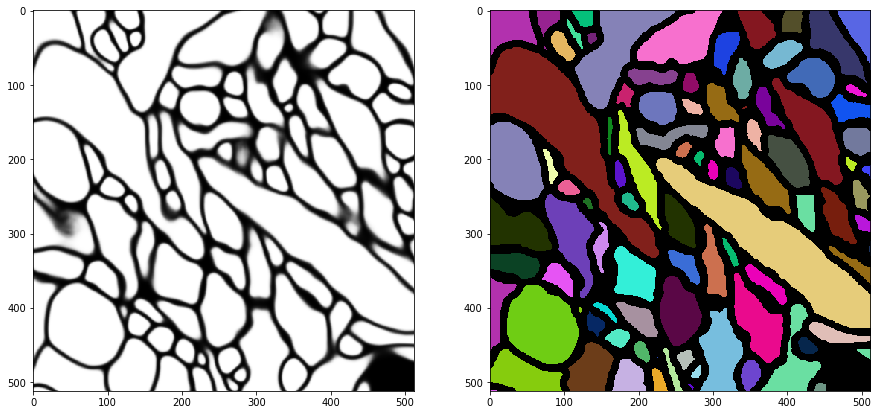

In [162]:
import matplotlib.pyplot as plt

z = 11
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(seg1[0,z,:,:], cmap='gray')
plt.subplot(1,2,2)
plot_seg(seg2[z,:,:], border=True)
plt.show()

In [163]:
xy = np.minimum(seg1[0,...],seg1[1,...])
# xy = (seg1[0,...] + seg1[1,...])/2.0
seg1[0,...] = xy
seg1[1,...] = xy
seg1[2,...] = np.minimum(seg1[2,...],xy)

In [164]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(seg1[0,z,:,:], cmap='gray')
plt.subplot(1,2,2)
plot_seg(seg2[z,:,:], border=True)
plt.show()

## Evaluator

In [165]:
import datatools

class ConnectedComponents(evaluator.Segment):
    def __init__(self, k=10):
        self.k = k
        
    def __call__(self, data, threshold=0.5, **kwargs):
        seg = datatools.get_segmentation(data, threshold)
        return datatools.dilate_segmentation(seg, k=self.k).astype('uint32')

In [166]:
seg = evaluator.Segmentation(seg1, segment=ConnectedComponents(k=1024))
# seg = evaluator.Segmentation(seg1)
gt = evaluator.Segmentation(seg2)

In [167]:
# ls = evaluator.LineSearch(depth=1, start=0.9, stop=1.0, step=0.01)
ls = evaluator.LineSearch(depth=1)
# ls = evaluator.LineSearch(depth=0, start=0.5, stop=0.6, step=0.1)

In [168]:
results, opt_thresh = ls(seg, gt, "voi")

Threshold = 0.100
voi error: 5.990

Threshold = 0.200
voi error: 4.400

Threshold = 0.300
voi error: 0.967

Threshold = 0.400
voi error: 0.255

Threshold = 0.500
voi error: 0.113

Threshold = 0.600
voi error: 0.093

Threshold = 0.700
voi error: 0.073

Threshold = 0.800
voi error: 0.094

Threshold = 0.900
voi error: 0.120

Threshold = 0.650
voi error: 0.071

Threshold = 0.750
voi error: 0.077

Threshold = 0.610
voi error: 0.093

Threshold = 0.620
voi error: 0.094

Threshold = 0.630
voi error: 0.094

Threshold = 0.640
voi error: 0.083

Threshold = 0.660
voi error: 0.071

Threshold = 0.670
voi error: 0.071

Threshold = 0.680
voi error: 0.072

Threshold = 0.690
voi error: 0.072

Optimal threshold = 0.65


In [169]:
results[opt_thresh]

{'voi': (0.07081736707240154, 0.019466824923598917, 0.051350542148802615)}

In [170]:
opt_seg = seg(threshold=opt_thresh)

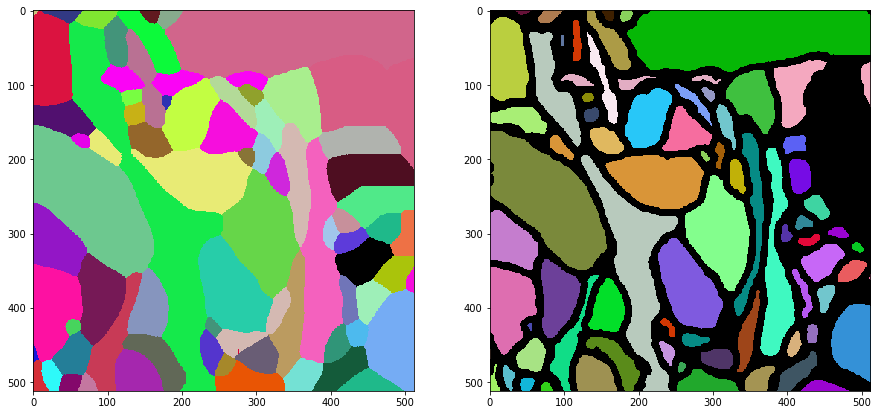

In [171]:
z = 97
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plot_seg(opt_seg[z,:,:], border=True)
plt.subplot(1,2,2)
plot_seg(seg2[z,:,:], border=True)
plt.show()

In [172]:
opt_seg[seg2==0] = 0

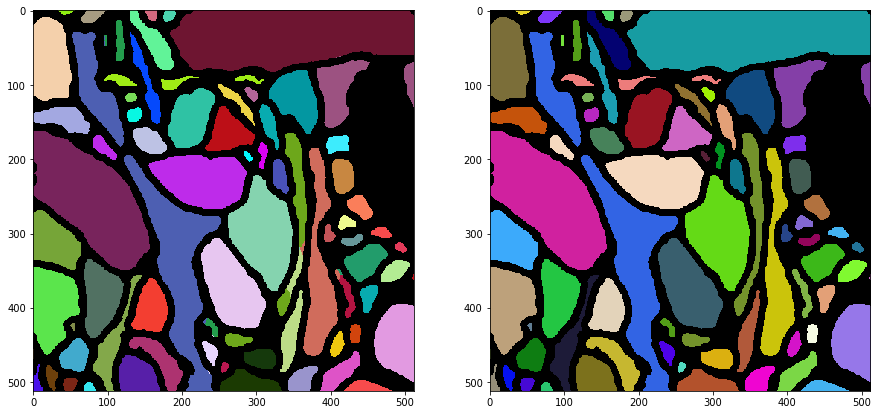

In [173]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plot_seg(opt_seg[z,:,:], border=True)
plt.subplot(1,2,2)
plot_seg(seg2[z,:,:], border=True)
plt.show()

## Save

In [174]:
import h5py
import os

In [175]:
fpath = '~/pytorch-deepem/experiments/kasthuri11/superhuman/direct/long/aug4/mip0/bce/depth4_patch160-20/forward/iter_200000/fov256-20/static/'
fpath = os.path.expanduser(fpath)
fpath = os.path.join(fpath, 'conn_comp.h5')

In [176]:
if not os.path.exists(os.path.dirname(fpath)):
    os.makedirs(os.path.dirname(fpath))

In [177]:
opt_seg = seg(threshold=opt_thresh)
thresh = list(results.keys())
merge = [v['voi'][1] for v in results.values()]
split = [v['voi'][2] for v in results.values()]

In [178]:
with h5py.File(fpath, 'w') as f:
    f.create_dataset('/main', data=opt_seg.astype('uint32'))
    f.create_dataset('/voi/thresholds', data=thresh)
    f.create_dataset('/voi/opt_thresh', data=opt_thresh)
    f.create_dataset('/voi/merge', data=merge)
    f.create_dataset('/voi/split', data=split)